# Adaboost ou XGBoost ?

Deux algorithmes de boosting connus sont Adaboost & XGBoost, voyons voir la performance de chacun de ces algorithmes sur le dataset d'AIRBNB Seattle. Notre but va être de prédire le prix d'un appartement en fonction des caractéristiques qu'on nous a donné. 

1. Importez les librairies usuelles 

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import ast
from datetime import datetime
from sklearn.impute import KNNImputer
#!pip install xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor 

In [56]:
%matplotlib inline

In [57]:
sns.set()

2. Importez le dataset ```listings.csv```

In [2]:
data = pd.read_csv('s3://full-stack-bigdata-datasets/Machine Learning Supervisé/Boosting/listings.csv')
data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

3. On a beaucoup de données dans ce dataset. Affichez toutes les colonnes du dataset

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

4. Révisons un peu Seaborn, affichez la distribution des prix dans le dataset 

In [8]:
data["price_num"] = data["price"].apply(lambda x: float(x.split('$')[1].replace(',','')))

<Figure size 1008x720 with 0 Axes>

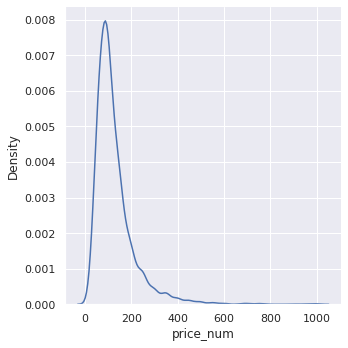

In [43]:
plt.figure(figsize=(14,10))
sns.displot(x = data['price_num'], kind='kde')
plt.show()

In [17]:
data['price_log'] = np.log(data['price_num'])

<Figure size 1008x504 with 0 Axes>

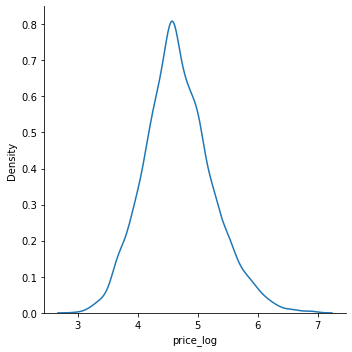

In [29]:
plt.figure(figsize=(14,7))
sns.displot(x = data['price_log'], kind='kde')
plt.show()

5. Supprimez les outliers pour ne garder que les appartements qui ont un prix inférieur à 400$/nuit 

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.755000e+03,3.755000e+03,3.755000e+03,3753.000000,3753.000000,3755.000000,3755.000000,3755.000000,3739.000000,3749.000000,3754.000000,96.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3755.000000,3119.000000,3108.000000,3113.000000,3108.000000,3115.000000,3111.000000,3110.000000,0.0,3755.000000,3138.000000
mean,5.556910e+06,2.016010e+13,1.579411e+07,7.146283,7.146283,47.628887,-122.332935,3.272703,1.236026,1.270739,1.690730,836.437500,120.749933,1.639414,2.365113,780.472703,16.821305,36.885220,58.189880,244.672703,22.443675,94.517153,9.635135,9.552843,9.784106,9.807705,9.607522,9.452412,NaN,2.944607,2.096539
std,2.966011e+06,0.000000e+00,1.459490e+07,28.711382,28.711382,0.043270,0.031759,1.868531,0.556459,0.824873,1.056105,650.483429,68.744681,1.236517,16.441420,1696.449365,12.161880,23.306987,34.007566,126.911684,37.980257,6.597540,0.700417,0.801180,0.599360,0.571147,0.629853,0.749495,NaN,5.882812,1.827941
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,1.000000,0.000000,20.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.256584e+06,2.016010e+13,3.258368e+06,1.000000,1.000000,47.609078,-122.354154,2.000000,1.000000,1.000000,1.000000,415.000000,75.000000,1.000000,1.000000,60.000000,2.000000,13.500000,29.000000,124.000000,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.700000
50%,6.127974e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623451,-122.328750,2.000000,1.000000,1.000000,1.000000,750.000000,100.000000,1.000000,2.000000,1125.000000,20.000000,46.000000,73.000000,308.000000,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.560000
75%,8.047928e+06,2.016010e+13,2.592334e+07,3.000000,3.000000,47.662976,-122.310698,4.000000,1.000000,2.000000,2.000000,1200.000000,150.000000,2.000000,2.000000,1125.000000,30.000000,59.000000,89.000000,360.000000,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.020000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,10.000000,3000.000000,400.000000,15.000000,1000.000000,100000.000000,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


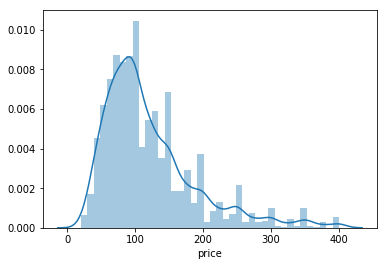

6. Exprimez le prix en fonction des variables suivantes : 

- ```room type```
- ```beds```
- ```property type```

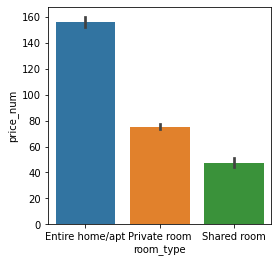

In [30]:
plt.figure(figsize=(4,4))
sns.barplot(data=data, x='room_type', y='price_num')
plt.show()

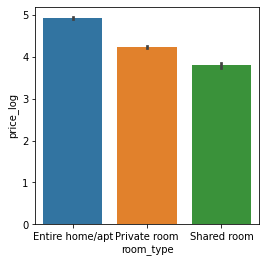

In [31]:
plt.figure(figsize=(4,4))
sns.barplot(data=data, x='room_type', y='price_log')
plt.show()

<AxesSubplot:xlabel='beds', ylabel='price_num'>

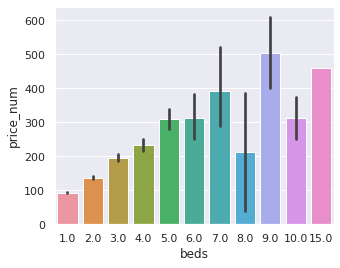

In [72]:
plt.figure(figsize=(5,4))
sns.barplot(data=data, x='beds', y='price_num')
#plt.show()

<AxesSubplot:xlabel='beds', ylabel='price_num'>

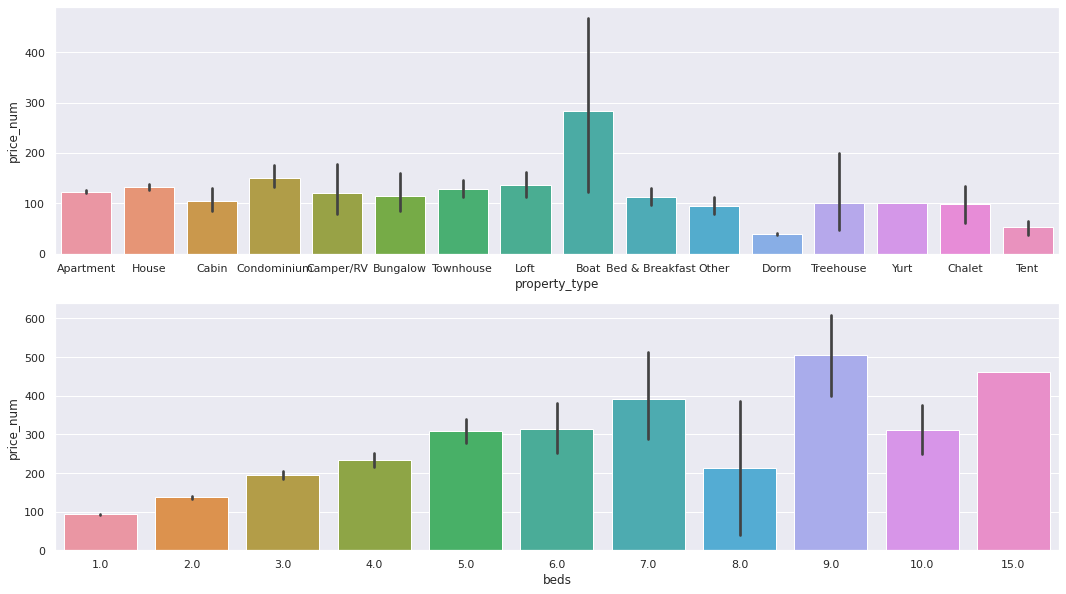

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,10))
sns.barplot(data=data, x='property_type', y='price_num', ax=axes[0],)
sns.barplot(data=data, x='beds', y='price_num', ax=axes[1])
#axes[0].set_title('mi plot')
#fig.figure

/home/carmina/miniconda3/envs/pez-jedha/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


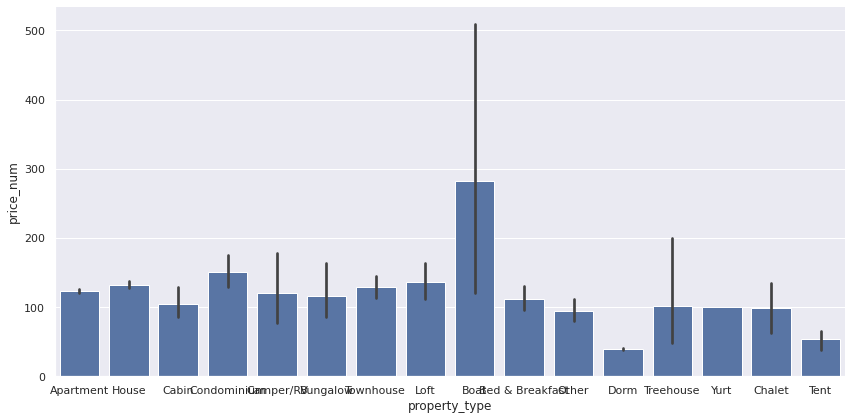

In [86]:
#plt.figure(figsize=(18,10))
g = sns.FacetGrid(data, height=6, aspect=2)
g.map(sns.barplot,"property_type", "price_num")

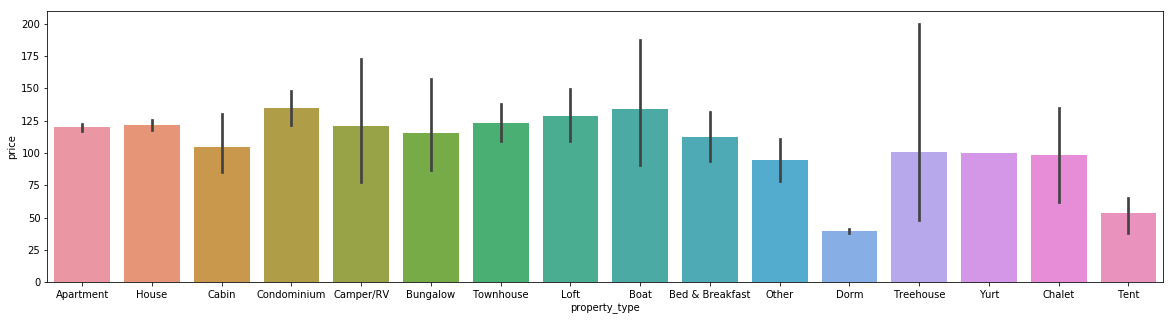

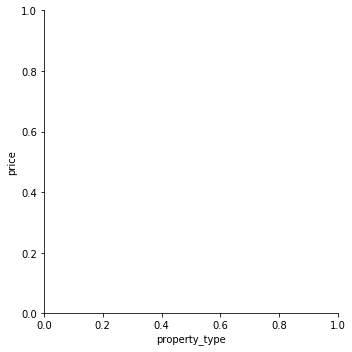

7. Séparez la variable cible de votre dataset

8. Il faut qu'on écrème quelques variables explicatives de notre jeu de données. Commencer par simplement enlever les variables qui expriment un ```id``` quelconque ou urls. On enlèvera également les variables qui contiennent des textes longs comme ```notes```

De la même manière, on enlèvera  toutes les variables qui décrivent le prix mensuel ou hebdomadaire comme  ```monthly price```

Votre dataset devrait contenir uniquement les variables catégoriques et numériques une fois votre nettoyage fait. 

A la fin, votre dataset contiendra les variables suivantes : 

```
Index(['experiences_offered', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')
```

license                             100.000000
square_feet                          97.443409
monthly_price                        60.053262
security_deposit                     51.504660
weekly_price                         47.270306
notes                                42.210386
cleaning_fee                         27.217044
neighborhood_overview                27.030626
transit                              24.474035
host_about                           22.556591
host_acceptance_rate                 19.946738
review_scores_accuracy               17.230360
review_scores_checkin                17.230360
review_scores_value                  17.177097
review_scores_location               17.150466
review_scores_cleanliness            17.097204
review_scores_communication          17.043941
review_scores_rating                 16.937417
last_review                          16.431425
first_review                         16.431425
reviews_per_month                    16.431425
space        

9 Reste-t-il des valeurs manquantes? Certaines peuvent elles être traîtées sans avoir recours à l'interpolation ? Les variables sont elles toutes dans un format adapté ? Si non appliquez des transformations adaptées.

experiences_offered                    0
calculated_host_listings_count         0
minimum_nights                         0
maximum_nights                         0
has_availability                       0
availability_30                        0
availability_60                        0
guests_included                        0
availability_90                        0
number_of_reviews                      0
requires_license                       0
instant_bookable                       0
cancellation_policy                    0
require_guest_profile_picture          0
require_guest_phone_verification       0
availability_365                       0
bed_type                               0
extra_people                           0
accommodates                           0
room_type                              0
longitude                              0
latitude                               0
neighbourhood_group_cleansed           0
property_type                          1
beds            

10. Vérifiez que toutes les variables numériques le sont effectivement bien. (N'oubliez pas de regarder y)

(3755, 98)

11. Séparez les variables en deux groupes, les variables numériques d'un côté et les qualitatives de l'autre.

12. Faites maintenant un ```train_test_split```

13. Normalisez ```X_train_num``` & ```X_test_num``` et rassemblez les deux groupes de variables

14. Gérez les valeurs NaN. Utilisez les stratégies que vous préférez 

,id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,host_response_rate_clean,experiences_offered_none,host_response_time_Unknown,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_acceptance_rate_0%,host_acceptance_rate_100%,host_is_superhost_Unknown,host_is_superhost_f,...,neighbourhood_group_cleansed_Rainier Valley,neighbourhood_group_cleansed_Seward Park,neighbourhood_group_cleansed_University District,neighbourhood_group_cleansed_West Seattle,property_type_Apartment,property_type_Bed & Breakfast,property_type_Boat,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Chalet,property_type_Condominium,property_type_Dorm,property_type_House,property_type_Loft,property_type_Other,property_type_Tent,property_type_Townhouse,property_type_Treehouse,property_type_Yurt,property_type_unknown,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,has_availability_t,requires_license_f,instant_bookable_f,instant_bookable_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_phone_verification_f,require_guest_phone_verification_t
2122,7324041.0,1.0,1.0,47.519449,-122.362499,4.0,1.0,0.0,1.0,0.0,0.38,2.0,18.0,1.0,30.0,24.0,54.0,84.0,171.0,24.0,98.0,10.0,10.0,10.0,10.0,9.0,10.0,1.0,4.210,1.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
24,1110749.0,9.0,9.0,47.635085,-122.364443,6.0,1.5,3.0,3.0,500.0,1.00,6.0,60.0,2.0,1125.0,23.0,50.0,77.0,162.0,68.0,92.0,9.0,9.0,10.0,9.0,10.0,9.0,8.0,2.180,0.970000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2760,8150395.0,1.0,1.0,47.618648,-122.315312,3.0,1.0,1.0,1.0,500.0,0.60,2.0,0.0,2.0,1125.0,17.0,26.0,55.0,55.0,6.0,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,1.620,0.900000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3320,2723368.0,1.0,1.0,47.671003,-122.359718,2.0,1.0,1.0,1.0,0.0,0.10,1.0,15.0,1.0,1125.0,3.0,33.0,63.0,338.0,43.0,95.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,2.090,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1326,2489283.0,34.0,34.0,47.613679,-122.349330,6.0,2.0,2.0,3.0,0.0,1.13,1.0,0.0,2.0,365.0,25.0,55.0,80.0,167.0,10.0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,6.0,0.470,0.940000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2750,458197.0,10.0,10.0,47.624915,-122.319729,2.0,2.0,1.0,2.0,250.0,0.39,1.0,10.0,2.0,14.0,0.0,0.0,0.0,2.0,7.0,83.0,9.0,9.0,10.0,9.0,9.0,9.0,9.0,0.160,1.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0

15. Entrainez d'abord un modèle d'Adaboost standard et regardez votre score 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.47222555710980174

price    122.798935
dtype: float64

16. Entrainez ensuite un modèle XGBoost et regardez votre score 

[08:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.6992089716665751

17. Par défaut, Adaboost prend des decision trees comme modèle a booster. Tentez de mettre une regression linéaire 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-563347451.5751352

0.6634775816216779

18. La régression linéaire n'était pas la meilleure idée mais peut être qu'on peut faire une grid_search sur le ```learning rate``` & ```n_estimators```pour rattraper le score de XGBoost ?

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=None),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
                         'n_estimators': [40, 50, 70, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'learning_rate': 0.5, 'n_estimators': 40}

0.5025760617765047

---> Même avec beaucoup plus d'estimateurs, nous n'arrivons pas au score de XGBoost